In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)
    
    cond_entropy = 0
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        est_nodes = tree.apply(X[vote_indices])
        est_classes = y[vote_indices]
        for i in range(len(est_nodes)):
            class_counts[est_nodes[i], est_classes[i]] += 1
        
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = class_probs[tree.apply(X[eval_indices])]
        # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy += np.mean(eval_entropies)
      
    return cond_entropy / n_estimators

### Generating data and prediction.

In [5]:
def generate_data(n, d, mu = 1, var1 = 1, pi = 0.5, three_class = False):
    
    means, Sigmas, probs = _make_params(d, mu = mu, var1 = var1, pi = pi, three_class = three_class)
    counts = np.random.multinomial(n, probs, size = 1)[0]
    
    X_data = []
    y_data = []
    for k in range(len(probs)):
        X_data.append(np.random.multivariate_normal(means[k], Sigmas[k], counts[k]))
        y_data.append(np.repeat(k, counts[k]))
    X = np.concatenate(tuple(X_data))
    y = np.concatenate(tuple(y_data))
    
    return X, y

def _make_params(d, mu = 1, var1 = 1, pi = 0.5, three_class = False):
    
    if three_class:
        return _make_three_class_params(d, mu, pi)
    
    mean = np.zeros(d)
    mean[0] = mu
    means = [mean, -mean]

    Sigma1 = np.eye(d)
    Sigma1[0, 0] = var1
    Sigmas = [np.eye(d), Sigma1]
    
    probs = [pi, 1 - pi]
    
    return means, Sigmas, probs

def _make_three_class_params(d, mu, pi):
    
    means = []
    mean = np.zeros(d)
    
    mean[0] = mu
    means.append(copy.deepcopy(mean))
    
    mean[0] = -mu
    means.append(copy.deepcopy(mean))
    
    mean[0] = 0
    mean[d-1] = mu
    means.append(copy.deepcopy(mean))
    
    Sigmas = [np.eye(d)]*3
    probs = [pi, (1 - pi) / 2, (1 - pi) / 2]
    
    return means, Sigmas, probs

## Plot the Setting ("Look at it!")

In [6]:
def plot_setting(n, setting, ax):
    
    mean = 3 if setting['name'] == 'Three Class Gaussians' else 1
    X, y = generate_data(n, 2, **setting['kwargs'], mu = mean)
        
    colors = ["#c51b7d", "#2166ac", "#d95f02"]
    ax.scatter(X[:, 0], X[:, 1], color = np.array(colors)[y], marker = ".")
    
    ax.set_xlim(left = -5.05)
    ax.set_xlim(right = 5.05)
    
    ax.set_ylabel(setting['name'])

In [7]:
# Setting figures.
settings = [
    {
        'name' : 'Sphereical Gaussians',
        'kwargs': {},
        'filename' : 'spherical'
    },
    {
        'name' : 'Elliptical Gaussians',
        'kwargs': {'var1' : 3},
        'filename' : 'ellyptical'
    },
    {
        'name' : 'Three Class Gaussians',
        'kwargs': {'three_class' : True},
        'filename' : 'three_class'
    },
]

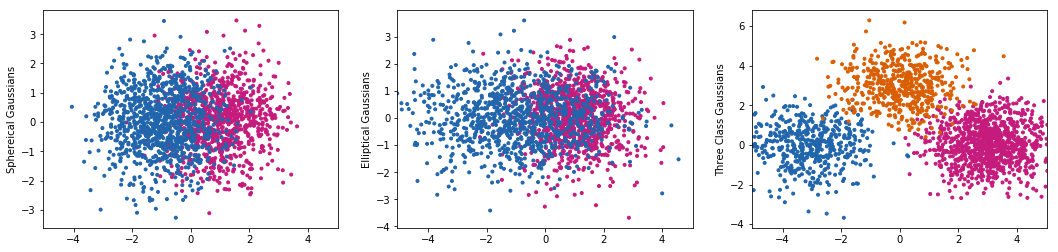

<Figure size 432x288 with 0 Axes>

In [8]:
# Plot data.
fig, axes = plt.subplots(1, len(settings), figsize = (18,4))
for i, setting in enumerate(settings):
    plot_setting(2000, setting, axes[i])
    
plt.show()
plt.clf()

## Effect Size Plots

In [9]:
def compute_mutual_info(d, base = np.exp(1), mu = 1, var1 = 1, pi = 0.5, three_class = False):
    
    if d > 1:
        dim = 2
    else:
        dim = 1
 
    means, Sigmas, probs = _make_params(dim, mu = mu, var1 = var1, pi = pi, three_class = three_class)
    
    # Compute entropy and X and Y.
    def func(*args):
        x = np.array(args)
        p = 0
        for k in range(len(means)):
            p += probs[k] * multivariate_normal.pdf(x, means[k], Sigmas[k])
        return -p * np.log(p) / np.log(base)

    scale = 10
    lims = [[-scale, scale]]*dim
    H_X, int_err = nquad(func, lims)
    H_Y = entropy(probs, base = base)
    
    # Compute MI.
    H_XY = 0
    for k in range(len(means)):
        H_XY += probs[k] * (dim * np.log(2*np.pi) + np.log(np.linalg.det(Sigmas[k])) + dim) / (2 * np.log(base))
    I_XY = H_X - H_XY
    
    return I_XY, H_X, H_Y

# Compute true values for normalized mutual info.
def compute_truth_pi(d, pis, setting):
    truth = np.zeros(len(pis))
    for i, pi in enumerate(pis):
        I_XY, H_X, H_Y = compute_mutual_info(d, pi = pi, **setting['kwargs'])
        truth[i] = I_XY / min(H_X, H_Y)
    
    pickle.dump(truth, open('output/truth_pi_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
    
# def compute_truth_mu(d, mus, setting):
#     truth = np.zeros(len(mus))
#     for i in range(len(mus)):
#         I_XY, H_X, H_Y = compute_mutual_info(d, **setting['kwargs'], mu = mus[i])
#         truth[i] = I_XY / min(H_X, H_Y)
        
#     pickle.dump(truth, open('truth_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))

In [10]:
def estimate_mi(X, y, label, est_H_Y, norm_factor):
    
    if label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 60), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return (est_H_Y - np.mean(entropy(p.T, base = np.exp(1)))) / norm_factor
    elif label == "UF":
        return (est_H_Y - uf(np.array(X), y)) / norm_factor
    elif label == "KSG":
        return mixed.KSG(X, y.reshape(-1, 1)) / norm_factor
    elif label == "Mixed KSG":
        return mixed.Mixed_KSG(X, y.reshape(-1, 1)) / norm_factor
    elif label == "UF2":
        return (est_H_Y - uf2(np.array(X), y)) / norm_factor
    elif label == "UF3":
        return UncertaintyForest().fit(X, y).estimate_mutual_info() / norm_factor
    else:
        raise ValueError("Unrecognized Label!")

In [11]:
# def get_mutual_info_vs_mu(n, d, num_trials, mus, algos, setting):
    
#     def worker(t):
#         X, y = generate_data(n, d, mu = elem, **setting['kwargs'])
        
#         I_XY, H_X, H_Y = compute_mutual_info(d, mu = elem, **setting['kwargs'])
#         norm_factor = min(H_X, H_Y)
        
#         _, counts = np.unique(y, return_counts=True)
#         est_H_Y = entropy(counts, base=np.exp(1))
        
#         ret = []
#         for algo in algos:
#             ret.append(estimate_mi(X, y, algo['label'], est_H_Y, norm_factor))

#         return tuple(ret)
    
#     output = np.zeros((len(algos), len(mus), num_trials))
#     for i, elem in enumerate(mus):
#         results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
#         for j in range(len(algos)):
#             output[j, i, :] = results[:, j]
    
#     pickle.dump(mus, open('mus.pkl', 'wb'))
#     for j, algo in enumerate(algos):
#         pickle.dump(output[j], open('%s_%s_by_mu_d_%d.pkl' % (setting['filename'], algo['label'], d), 'wb'))
        
#     return output

def get_mutual_info_vs_pi(n, d, pis, num_trials, algos, setting):
    
    def worker(t):
        X, y = generate_data(n, d, pi = elem, **setting['kwargs'])
        
        I_XY, H_X, H_Y = compute_mutual_info(d, pi = elem, **setting['kwargs'])
        norm_factor = min(H_X, H_Y)
        
        _, counts = np.unique(y, return_counts=True)
        est_H_Y = entropy(counts, base=np.exp(1))
        
        ret = []
        for algo in algos:
            ret.append(estimate_mi(X, y, algo['label'], est_H_Y, norm_factor))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(pis), num_trials))
    for i, elem in enumerate(pis):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(pis, open('output/pis.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('output/%s_%s_by_pi_d_%d.pkl' % (setting['filename'], algo['label'], d), 'wb'))
        
    return output

def get_mutual_info_vs_d(n, ds, num_trials, mu, algos, setting):
    
    def worker(t):
        X, y = generate_data(n, elem, mu = mu, **setting['kwargs'])
        
        I_XY, H_X, H_Y = compute_mutual_info(elem, mu = mu, **setting['kwargs'])
        norm_factor = min(H_X, H_Y)
        
        _, counts = np.unique(y, return_counts=True)
        est_H_Y = entropy(counts, base=np.exp(1))
        
        ret = []
        for algo in algos:
            ret.append(estimate_mi(X, y, algo['label'], est_H_Y, norm_factor))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(ds), num_trials))
    for i, elem in enumerate(ds):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(ds, open('output/ds.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('output/%s_%s_by_d.pkl' % (setting['filename'], algo['label']), 'wb'))
        
    return output

In [12]:
# def plot_mutual_info_by_mu(setting, algos, d, ax):
#     mus = pickle.load(open('mus.pkl', 'rb'))
#     for j, algo in enumerate(algos):
#         result = pickle.load(open('%s_%s_by_mu_d_%d.pkl' % (setting['filename'], algo['label'], d), 'rb'))
#         # Plot the mean over trials as a solid line.
#         ax.plot(mus,
#                 np.mean(result, axis = 1).flatten(), 
#                 label = algo['label'], 
#                 linewidth = 4, 
#                 color = algo['color'])

#     truth = pickle.load(open('truth_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
#     ax.plot(mus, truth, label = 'Truth', linewidth = 2, color = 'black')

#     ax.set_xlabel("Effect Size")
#     ax.set_xlim(left = np.amin(mus) - 0.05)
#     ax.set_xlim(right = np.amax(mus) + 0.05)
#     ax.set_ylim(bottom = -0.05)
#     ax.set_ylim(top = 1.05)
#     ax.set_ylabel("Estimated Normalized MI")

def plot_mutual_info_by_pi(setting, algos, d, ax):
    pis = pickle.load(open('output/pis.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('output/%s_%s_by_pi_d_%d.pkl' % (setting['filename'], algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(pis,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        
    # ax.set_yscale('log')

    truth = pickle.load(open('output/truth_pi_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
    ax.plot(pis, truth, label = 'Truth', linewidth = 2, color = 'black')

    ax.set_xlabel("Class Prior")
    ax.set_xlim((np.amin(pis) - 0.05, np.amax(pis) + 0.05))
    ax.set_ylim((-0.05, 0.55))
    ax.set_ylabel("Estimated Normalized MI")
    
def plot_mutual_info_by_d(setting, algos, mu, ax):
    ds = pickle.load(open('output/ds.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('output/%s_%s_by_d.pkl' % (setting['filename'], algo['label']), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(ds,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])

    I_XY, H_X, H_Y = compute_mutual_info(2, **setting['kwargs'], mu = mu)
    truth = np.repeat(I_XY / min(H_X, H_Y), len(ds))
    ax.plot(ds, truth, label = 'Truth', linewidth = 2, color = 'black')

    ax.set_xlabel("Dimensionality")
    ax.set_xlim(left = np.amin(ds) - 0.05)
    ax.set_xlim(right = np.amax(ds) + 0.05)
    ax.set_ylim((-0.05, 0.55))
    ax.set_ylabel("Estimated Normalized MI")

In [13]:
# Params.
n = 6000
mus = range(5)
ds = range(1, 16)
mu = 1
num_trials = 20
d = 2
pis = [0.05 * i for i in range(1, 20)]

# Test params.
# n = 400
# mus = range(3)
# ds = range(2, 5)
# mu = 1
# num_trials = 3
# d = 1
# pis = [0.05 * i for i in range(3, 6)]

# Algorithms.
algos = [
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'KSG',
        'title': 'KSG',
        'color': "#1b9e77",
    },
    {
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "purple",
    },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

In [14]:
for setting in settings:
    # compute_truth_mu(d, mus, setting)
    compute_truth_pi(d, pis, setting)

In [15]:
# for setting in settings:
#     get_mutual_info_vs_mu(n, d1, num_trials, mus, algos, setting)

In [16]:
for setting in settings:
    get_mutual_info_vs_pi(n, d, pis, num_trials, algos, setting)

In [17]:
for setting in settings:
    get_mutual_info_vs_d(n, ds, num_trials, mu, algos, setting)

In [14]:
def plot_fig3(algos, n, d, mu, settings):
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    fig, axes = plt.subplots(len(settings), 3, figsize = (15,13))

    for s, setting in enumerate(settings):
        plot_setting(2000, setting, axes[s, 0])
        plot_mutual_info_by_pi(setting, algos, d, axes[s, 1])
        plot_mutual_info_by_d(setting, algos, mu, axes[s, 2])
        
    axes[0, 1].set_title('n = %d, d = %d' % (n, d))
    axes[0, 2].set_title('n = %d, Effect Size = %.1f' % (n, mu))
    axes[2, 2].legend(loc = "lower right")

    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.tight_layout()
    plt.savefig("fig3.pdf")
    plt.show()

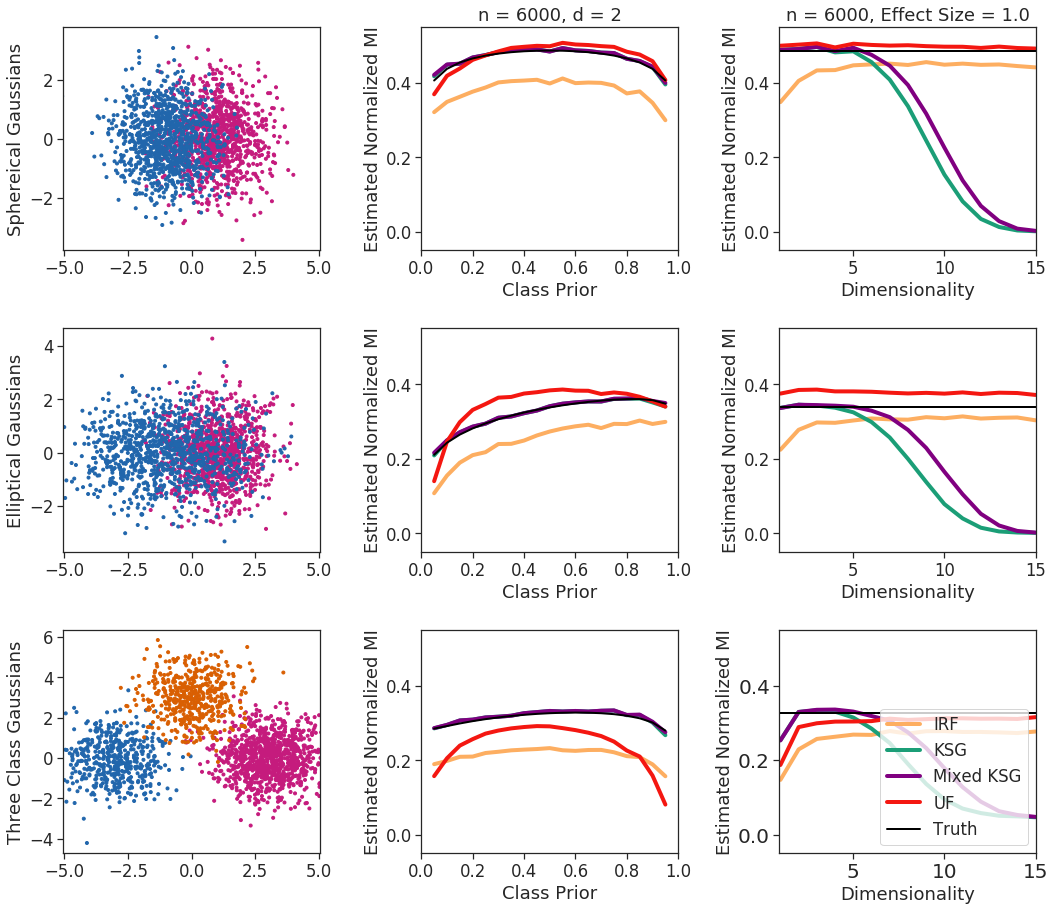

In [15]:
plot_fig3(algos, n, d, mu, settings)